## What is Persistence in LangGraph?




Persistence in LangGraph refers to the ability to save and restore the state of the workflow over time.

LangGraph has a built-in persistence layer, implemented through checkpointers. When you compile a graph with a checkpointer, the checkpointer saves a checkpoint of the graph state at every super-step. Those checkpoints are saved to a thread, which can be accessed after graph execution. Because threads allow access to graph's state after execution, several powerful capabilities including human-in-the-loop, memory, time travel, and fault-tolerance are all possible.

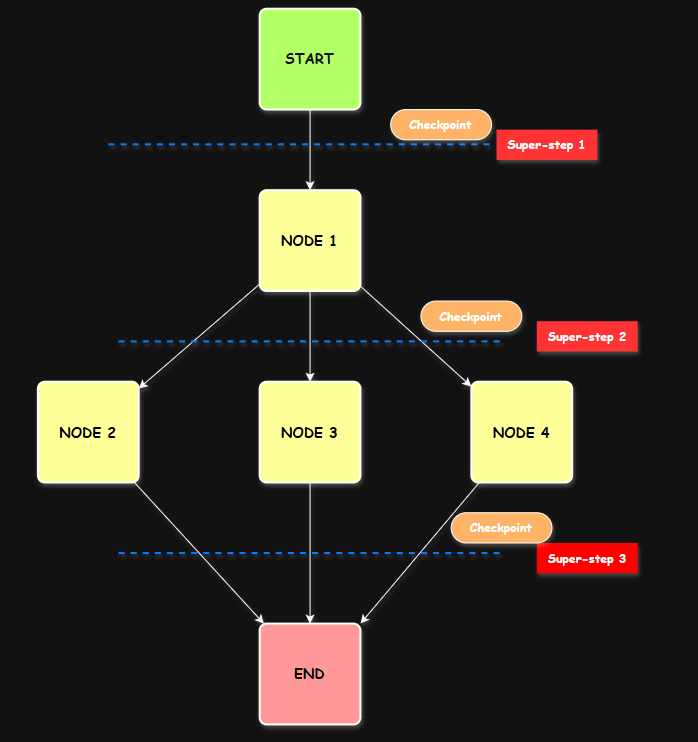

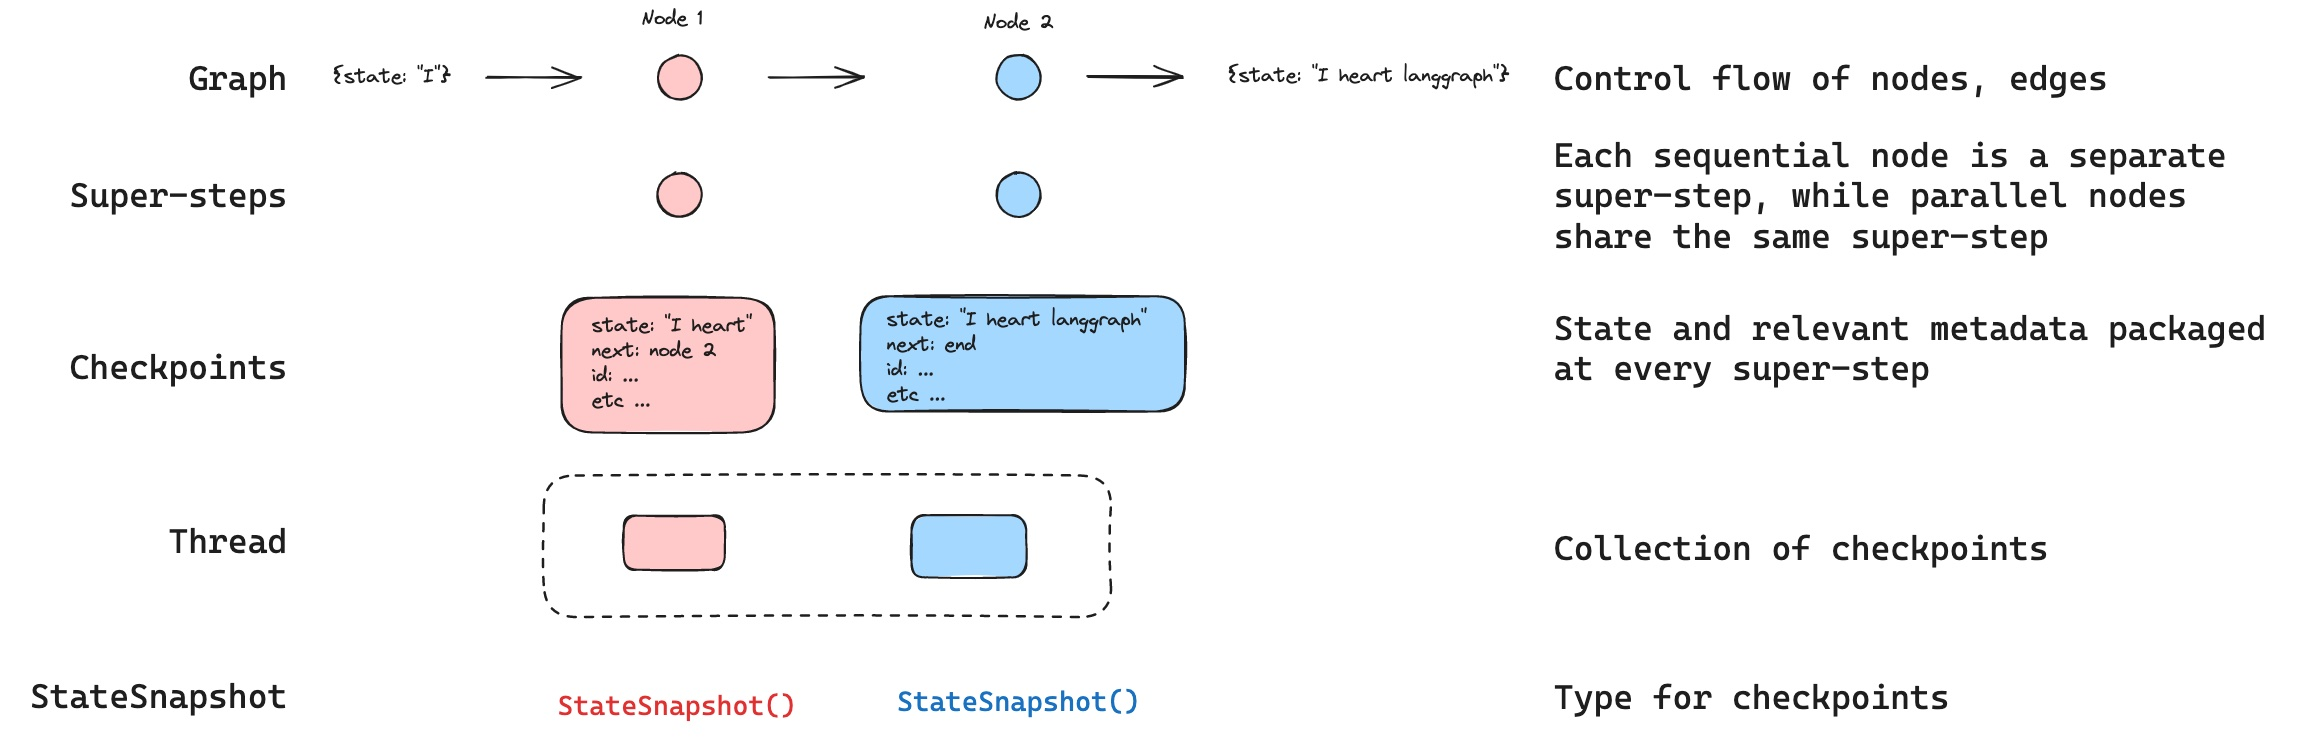

Let's try to replicate the concepts using a Joke Generator sequential workflow.
### Joke Generator Sequential Workflow

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
load_dotenv()

llm = ChatOpenAI()


In [ ]:
"""
This module defines a workflow for generating and explaining jokes based on a given topic.
It includes functions to generate a joke and explain it, using a state graph to manage the workflow.
"""

class JokeState(TypedDict):
    """State for the joke workflow."""
    topic: str
    joke: str 
    explanation: str

def geberate_joke(state: JokeState):
    """Generate a joke based on the topic."""
    prompt = f"Generate a joke about {state['topic']}."
    joke = llm.invoke(prompt).content

    return {"joke": joke}

def explain_joke(state: JokeState):
    """Explain the joke generated."""
    prompt = f"Explain the joke: {state['joke']}."
    explanation = llm.invoke(prompt).content

    return {"explanation": explanation}
    

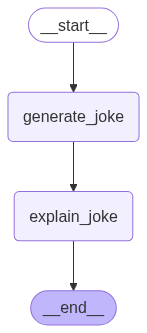

In [ ]:
"""
Define the state graph for the joke generation and explanation workflow.
This graph includes nodes for generating a joke and explaining it, with edges connecting the nodes to define the workflow.
"""

graph = StateGraph(JokeState)

graph.add_node("generate_joke", geberate_joke)
graph.add_node("explain_joke", explain_joke)

graph.add_edge(START, "generate_joke")
graph.add_edge("generate_joke", "explain_joke")
graph.add_edge("explain_joke", END)

ckpt = InMemorySaver()

workflow = graph.compile(checkpointer=ckpt)

workflow

 **Thread**

A thread is a unique ID or thread identifier assigned to each checkpoint saved by a checkpointer. It contains the accumulated state of a sequence of runs. When a run is executed, the state of the underlying graph of the assistant will be persisted to the thread.

When invoking a graph with a checkpointer, you must specify a thread_id as part of the configurable portion of the config.


**Checkpoints**

The state of a thread at a particular point in time is called a checkpoint. Checkpoint is a snapshot of the graph state saved at each super-step and is represented by StateSnapshot object with the following key properties:

- config: Config associated with this checkpoint.
- metadata: Metadata associated with this checkpoint.
- values: Values of the state channels at this point in time.
next A tuple of the node names to execute next in the graph.
- tasks: A tuple of PregelTask objects that contain information about next tasks to be executed. If the step was previously attempted, it will include error information. If a graph was interrupted dynamically from within a node, tasks will contain additional data associated with interrupts.

In [9]:
config1 = {"configurable": {"thread_id": 1}}
workflow.invoke({"topic": "AI in India"}, config=config1)



{'topic': 'AI in India',
 'joke': 'Why did the AI move to India?\n\nBecause it heard they have a great network!',
 'explanation': 'This joke plays on the double meaning of the word "network." In one sense, "network" can refer to a computer network or internet connection, which would be important for an AI. In another sense, "network" can refer to the social or professional connections one might have in a certain location. The joke suggests that the AI moved to India because it heard they have a great internet network, when in fact it could also be interpreted as moving there to establish a strong social or professional network.'}

**Get state**

When interacting with the saved graph state, you must specify a thread identifier. You can view the latest state of the graph by calling `graph.get_state(config)`. This will return a StateSnapshot object that corresponds to the latest checkpoint associated with the thread ID provided in the config or a checkpoint associated with a checkpoint ID for the thread, if provided.

In [10]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'AI in India', 'joke': 'Why did the AI move to India?\n\nBecause it heard they have a great network!', 'explanation': 'This joke plays on the double meaning of the word "network." In one sense, "network" can refer to a computer network or internet connection, which would be important for an AI. In another sense, "network" can refer to the social or professional connections one might have in a certain location. The joke suggests that the AI moved to India because it heard they have a great internet network, when in fact it could also be interpreted as moving there to establish a strong social or professional network.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f075bcb-7016-65db-8002-6028d2c7c7f2'}}, metadata={'source': 'loop', 'writes': {'explain_joke': {'explanation': 'This joke plays on the double meaning of the word "network." In one sense, "network" can refer to a computer network or internet connectio

**Get state history**

You can get the full history of the graph execution for a given thread by calling `graph.get_state_history(config)`. This will return a list of StateSnapshot objects associated with the thread ID provided in the config. Importantly, the checkpoints will be ordered chronologically with the most recent checkpoint / StateSnapshot being the first in the list.

In [11]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'AI in India', 'joke': 'Why did the AI move to India?\n\nBecause it heard they have a great network!', 'explanation': 'This joke plays on the double meaning of the word "network." In one sense, "network" can refer to a computer network or internet connection, which would be important for an AI. In another sense, "network" can refer to the social or professional connections one might have in a certain location. The joke suggests that the AI moved to India because it heard they have a great internet network, when in fact it could also be interpreted as moving there to establish a strong social or professional network.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f075bcb-7016-65db-8002-6028d2c7c7f2'}}, metadata={'source': 'loop', 'writes': {'explain_joke': {'explanation': 'This joke plays on the double meaning of the word "network." In one sense, "network" can refer to a computer network or internet connecti